In [3]:
%matplotlib nbagg

import os
import h5py
import numpy as np
from sklearn import svm
import pickle
from sklearn.externals import joblib
from sklearn import preprocessing
from skimage.morphology import binary_dilation
from wmem import utils, stack2stack

datadir = "/Users/michielk/oxdata/P01/EM/M3/M3S1GNU"
dataset = 'M3S1GNUds7'

clfpath = os.path.join(datadir, '{}_clf.pkl'.format(dataset))
scalerpath = os.path.join(datadir, '{}_scaler.pkl'.format(dataset))

labelfile = '{}_labels.h5'.format(dataset)
labeldset = 'labelMA_core2D'
labelpath = os.path.join(datadir, labelfile, labeldset)

maskfile = '{}_maskMA_final.h5'.format(dataset)  # NOTE: has old matrix size
maskdset = 'stack'
maskpath = os.path.join(datadir, maskfile, maskdset)

basename = os.path.join(datadir, '{}_labels_mapall'.format(dataset) )

gtpath = '{}_{}.npy'.format(basename, 'groundtruth')
predpath = '{}_{}.npy'.format(basename, 'pred')

props = ('label', 'area', 'eccentricity', 'mean_intensity',
         'solidity', 'extent', 'euler_number')

float_formatter = lambda x: "%.02f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})


In [5]:
# determine ground truth

## get 2D labels and mask of identified 3D MA compartment
f = h5py.File(os.path.join(datadir, labelfile), 'r')
labels = f[labeldset][:]
f.close()

# NOTE: M3S1GNUds7_maskMA_final.h5 has old matrix size
# m = h5py.File(os.path.join(datadir, maskfile), 'r')
# mask = m['stack'][:].astype('bool')
# m.close()
mask = np.zeros_like(labels, dtype='bool')
m = h5py.File(os.path.join(datadir, maskfile), 'r')
mask[:, :-1, :-1] = m[maskdset][:].astype('bool')
m.close()


In [9]:
## split the labels in MA and notMA
labelsALL = np.unique(labels)
maskdil = binary_dilation(mask)
labelsMA = np.unique(labels[maskdil])
labelsNOTMA = np.unique(labels[~maskdil])


In [10]:
## filter labels that are split between compartments
labelsTRUE = set(labelsMA) - set(labelsNOTMA)
labelsFALSE = set(labelsALL) - set(labelsMA)
print(len(labelsTRUE), len(labelsFALSE))

## generate final ground truth labels
y = np.zeros_like(labelsALL, dtype='bool')
for l in labelsTRUE:
    y[l] = True
y[0] = False
np.save(gtpath, y)


(775888, 202752)


In [11]:
# map the groundtruth labels to a volume

h5file_in, ds_in, elsize, axlab = utils.h5_load(labelpath)

h5path_out = os.path.join(datadir, '{}_gt.h5'.format(dataset))

h5file_out, ds_out = utils.h5_write(None, ds_in.shape, 'uint8',
                                    os.path.join(h5path_out, 'class0'),
                                    element_size_um=elsize,
                                    axislabels=axlab)
ds_out[:] = ~y[ds_in[:]]
h5file_out.close()

h5file_out, ds_out = utils.h5_write(None, ds_in.shape, 'uint8',
                                    os.path.join(h5path_out, 'class1'),
                                    element_size_um=elsize,
                                    axislabels=axlab)
ds_out[:] = y[ds_in[:]]
h5file_out.close()

h5file_in.close()

# convert to nifti
niipath_out = os.path.join(datadir, '{}_gt_class0.nii.gz'.format(dataset))
_ = stack2stack.stack2stack(os.path.join(h5path_out, 'class0'), niipath_out, inlayout='zyx', outlayout='xyz')
niipath_out = os.path.join(datadir, '{}_gt_class1.nii.gz'.format(dataset))
_ = stack2stack.stack2stack(os.path.join(h5path_out, 'class1'), niipath_out, inlayout='zyx', outlayout='xyz')


INFO: writing to /Users/michielk/oxdata/P01/EM/M3/M3S1GNU
INFO: writing to /Users/michielk/oxdata/P01/EM/M3/M3S1GNU


In [12]:
# load the ground truth labels and remove the background
y_train = np.load(gtpath)
y_train = y_train[1:]
print(np.sum(y_train), np.sum(~y_train))


(775888, 227710)


In [13]:
# load the training data (minus the background label)
X_train = np.zeros([y_train.shape[0], len(props) - 1])
for i, propname in enumerate(props[1:]):
    nppath = '{}_{}.npy'.format(basename, propname)
    X_train[:,i] = np.load(nppath)[1:]


In [14]:
# scale the training data
print(np.mean(X_train, axis=0))
print(np.mean(X_train[y_train,:], axis=0))
print(np.mean(X_train[~y_train,:], axis=0))

# X_train_scaled = preprocessing.scale(X_train)
# scaler = preprocessing.StandardScaler().fit(X_train)
# print(scaler.mean_)
# print(scaler.scale_)
# X_train_scaled = scaler.transform(X_train)
scaler = preprocessing.MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
joblib.dump(scaler, scalerpath)


[276.94 0.74 0.74 0.86 0.61 0.88]
[62.80 0.77 0.80 0.86 0.58 1.00]
[1006.61 0.64 0.53 0.87 0.69 0.48]


['/Users/michielk/oxdata/P01/EM/M3/M3S1GNU/scaler_test.pkl']

<IPython.core.display.Javascript object>


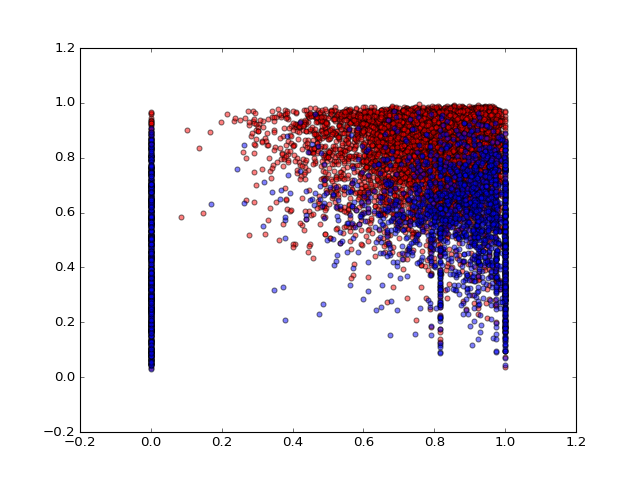

((775888, 6), (227710, 6))


In [15]:
# plot the training data
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm

plt.figure()
X0 = X_train_scaled[y_train,:]
X1 = X_train_scaled[~y_train,:]
print(X0.shape, X1.shape)

plt.scatter(X0[::100, 1], X0[::100, 2], c=[1,0,0],
            alpha=0.5, edgecolor='k',
            label="Class0")
plt.scatter(X1[::100, 1], X1[::100, 2], c=[0,0,1],
            alpha=0.5, edgecolor='k',
            label="Class1")


In [16]:
# fit the support vector classifier
clf = svm.SVC()
# clf.fit(X_train_scaled[::100], y_train[::100])
clf.fit(X_train_scaled, y_train)
joblib.dump(clf, clfpath)
joblib.dump(scaler, scalerpath)


['/Users/michielk/oxdata/P01/EM/M3/M3S1GNU/scaler_test.pkl']

In [25]:
# print(pred)
# print(pred_gt)
pred_gt = y
a = np.logical_xor(pred, pred_gt)
print(len(a), np.sum(~a) / float(len(a)))


ValueError: operands could not be broadcast together with shapes (794866,) (1003599,) 

In [ ]:
h5path_out = os.path.join(datadir, 'M3S1GNUds7_pred.h5', 'stack')
h5file_in, ds_in, elsize, axlab = utils.h5_load(labelpath)
h5file_out, ds_out = utils.h5_write(None, ds_in.shape, 'uint8',
                                    h5path_out,
                                    element_size_um=elsize,
                                    axislabels=axlab)

ds_out[:] = fw[ds_in[:]]

h5file_in.close()
h5file_out.close()

niipath_out = os.path.join(datadir, 'M3S1GNUds7_pred.nii.gz')
_ = stack2stack.stack2stack(h5path_out, niipath_out, inlayout='zyx', outlayout='xyz')
